In [2004]:
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import spline
from scipy.interpolate import BSpline

In [2005]:
%matplotlib inline
pd.set_option('display.max_columns', 500)

## Reading in the CSV

In [2006]:
df = pd.read_csv(
    'ny_phil.csv', 
    dtype={'interval': object},
    error_bad_lines=False)
df['Date'] = pd.to_datetime(df['Date'])

In [2007]:
df.shape

(806179, 17)

## Get some information

In [2008]:
len(df['composerName'].unique())

2767

In [2009]:
len(df['Location'].unique())

490

## Instruments

In [2010]:
df['soloistInstrument'].value_counts().head()

Dancer     77108
Soprano    72563
Piano      72188
Violin     52903
Trumpet    46454
Name: soloistInstrument, dtype: int64

In [2011]:
df.groupby('soloistInstrument').filter(lambda x: (len(x)<500) & (len(x) > 100))['soloistInstrument'].unique()

array(['Bass Clarinet', 'Vocal Group', 'Unspecified Voice',
       'Vocal Quartet', 'String Quartet', 'Solo Voice', 'Drum',
       'Xylophone', 'Folk Singer', 'Contrabassoon', "Oboe d'Amore",
       'Theremin', 'Viola da Gamba', 'Basset Horn', 'Accordion',
       'Drummers and Dancers', 'Folk Group', 'Saxophone', 'Harmonica',
       'Mime', 'Boy Soprano', 'Mandolin', 'Male Voice', 'Balladeer',
       'Marionettes', 'Recorder', 'Cimbalom', 'Jazz Quartet', 'Jazz Piano',
       'Alto Saxophone', 'Ensemble, Featured', 'Tenor Saxophone',
       'Tarabuka', 'Oud', 'Electric Guitar', 'Celeste', 'Euphonium',
       'Clapping and Vocals', 'Keyboard', 'Sheng', 'Author',
       'Production Design', 'Trombone/Baritone', 'Storywriter'], dtype=object)

In [2012]:
df_intruments = (df.groupby(df.Date.dt.year)
                 ['soloistInstrument'].value_counts(normalize=True)
                 .reset_index(name='count'))

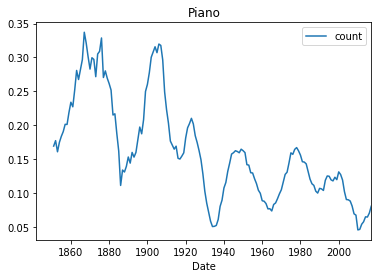

In [2013]:
(df_intruments[df_intruments['soloistInstrument'] == 'Piano']
 .rolling(10, on='Date').mean()
 .plot(x='Date', y='count', title='Piano'))

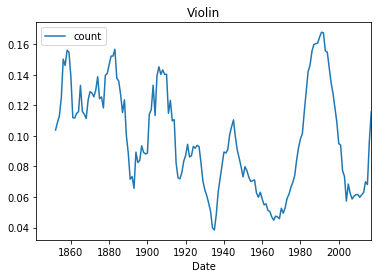

In [2014]:
(df_intruments[df_intruments['soloistInstrument'] == 'Violin']
 .rolling(10, on='Date').mean()
 .plot(x='Date', y='count', title='Violin'))

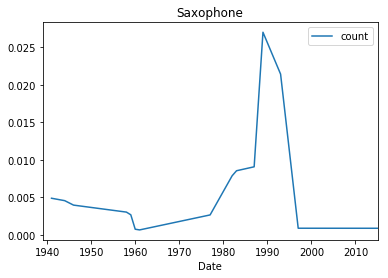

In [2015]:
(df_intruments[df_intruments['soloistInstrument'] == 'Saxophone']
 .rolling(2, on='Date').mean()
 .plot(x='Date', y='count', title='Saxophone'))

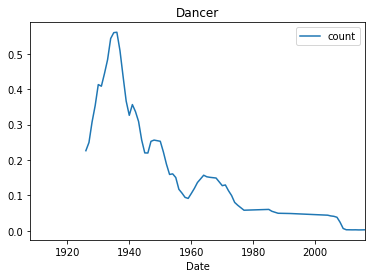

In [2016]:
(df_intruments[df_intruments['soloistInstrument'] == 'Dancer']
 .rolling(10, on='Date').mean()
 .plot(x='Date', y='count', title='Dancer'))

In [2017]:
# Isolate the instruments
df_intruments = df[['soloistInstrument', 'Date']]
#df_intruments.drop_duplicates(inplace=True)

In [2018]:
# The 10 most popular solo instruments
popular_instruments_list = df_intruments['soloistInstrument'].value_counts().nlargest(10).index.tolist()
popular_instruments = df_intruments[df_intruments.soloistInstrument.isin(popular_instruments_list)]
popular_instruments_list

['Dancer',
 'Soprano',
 'Piano',
 'Violin',
 'Trumpet',
 'Chorus',
 'Tenor',
 'Cello',
 'Baritone',
 'French Horn']

In [2019]:
# Plot the 10 most popular instruments over time
popular_instruments_plot = (popular_instruments
 .groupby(popular_instruments.Date.dt.year)
 ['soloistInstrument'].value_counts(normalize=True).reset_index(name='count'))

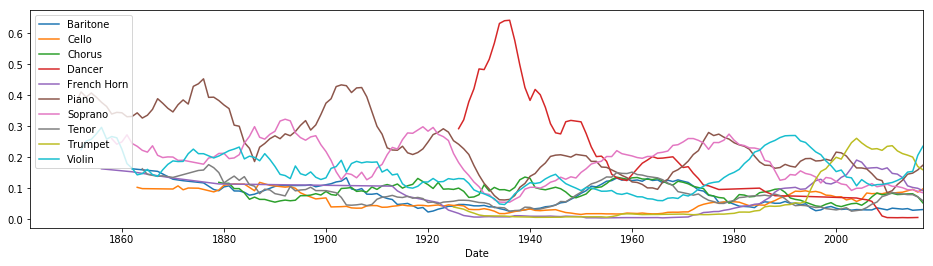

In [2020]:
fig, ax = plt.subplots(figsize=(16,4))

for label, dfi in popular_instruments_plot.groupby('soloistInstrument'):
    dfi.rolling(10, on='Date').mean().plot(x='Date', y='count', ax=ax, label=label)
    
plt.show()

## Number of concerts

In [2021]:
df_date = df.copy()
df_date.index = df['Date']

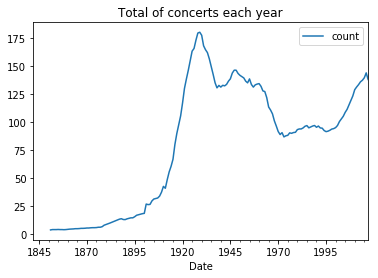

In [2022]:
(df_date.resample('A')
 ['id'].nunique()
 .reset_index(name='count')
 .rolling(10, on='Date').mean()
 .plot(x='Date', y='count', title='Total of concerts each year'))

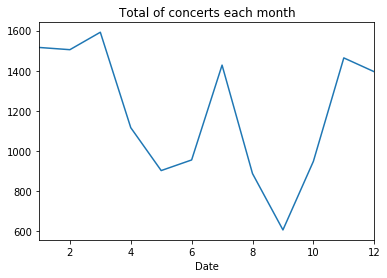

In [2023]:
(df_date.groupby(df_date.index.month)
 ['id'].nunique()
 .plot(title='Total of concerts each month'))

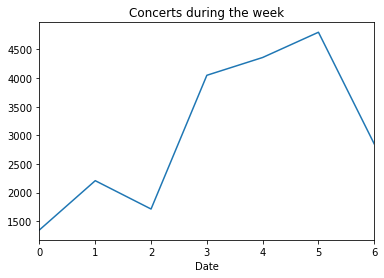

In [2024]:
(df_date.groupby(df_date.index.dayofweek)
 ['id'].nunique()
 .plot(y='id', title='Concerts during the week'))

In [2025]:
ltest = [{'d':1892, 'l':0,}, {'d':1893, 'l':1}, {'d':1894, 'l':2}, {'d':1895, 'l':3}]
ltest = pd.DataFrame(ltest)
ltest.groupby(ltest.index//2)['l'].mean()

0    0.5
1    2.5
Name: l, dtype: float64

In [2026]:
ltest.groupby(ltest.d//2)['l'].mean().reset_index()['l']

0    0.5
1    2.5
Name: l, dtype: float64

## Composers

In [2027]:
# Isolate the composers and get rid of the duplicates
df_composers = df.copy()[['Date', 'composerName', 'workTitle']]
df_composers.drop_duplicates(inplace=True)

In [2028]:
# Most played composer by year
(df_composers.groupby(df_composers.Date.dt.year)
 ['composerName'].value_counts()
 .groupby(level=0, group_keys=False)
 .nlargest(1)
 .tail(12))

Date  composerName               
2006  Mozart,  Wolfgang  Amadeus     93
2007  Brahms,  Johannes              67
2008  Beethoven,  Ludwig  van        46
2009  Beethoven,  Ludwig  van        47
2010  Mozart,  Wolfgang  Amadeus     63
2011  Beethoven,  Ludwig  van        54
2012  Tchaikovsky,  Pyotr  Ilyich    62
2013  Bach,  Johann  Sebastian       57
2014  Beethoven,  Ludwig  van        59
2015  Rachmaninoff,  Sergei          46
2016  Beethoven,  Ludwig  van        45
2017  Beethoven,  Ludwig  van        30
Name: composerName, dtype: int64

In [2029]:
# The 10 most popular composers list
popular_composers_list = df_composers['composerName'].value_counts().nlargest(10).index.tolist()
popular_composers_list

['Beethoven,  Ludwig  van',
 'Wagner,  Richard',
 'Tchaikovsky,  Pyotr  Ilyich',
 'Mozart,  Wolfgang  Amadeus',
 'Brahms,  Johannes',
 'Strauss,  Richard',
 'Bach,  Johann  Sebastian',
 'Mendelssohn,  Felix',
 'Dvorak,  Antonín',
 'Ravel,  Maurice']

In [2030]:
# The 10 most popular composers df
popular_composers = df_composers[df_composers.composerName.isin(popular_composers_list)]
popular_composers.head()

,Date,composerName,workTitle
0,1842-12-07 05:00:00,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67"
60,1842-12-07 05:00:00,"Beethoven, Ludwig van","FIDELIO, OP. 72"
70,1842-12-07 05:00:00,"Mozart, Wolfgang Amadeus","ABDUCTION FROM THE SERAGLIO,THE, K.384"
90,1843-02-18 05:00:00,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)"
135,1843-04-07 05:00:00,"Beethoven, Ludwig van","EGMONT, OP.84"


In [2031]:
len(popular_composers)

31789

In [2032]:
# The 10 most popular composers as one entity df
popular_composers_one = popular_composers.copy()
popular_composers_one['composerName'] = 'Popular'
popular_composers_one = popular_composers_one.drop('workTitle', 1)
popular_composers_one.head()

,Date,composerName
0,1842-12-07 05:00:00,Popular
60,1842-12-07 05:00:00,Popular
70,1842-12-07 05:00:00,Popular
90,1843-02-18 05:00:00,Popular
135,1843-04-07 05:00:00,Popular


In [2033]:
# The others df
other_composers = df_composers[~df_composers.composerName.isin(popular_composers_list)]
other_composers.head()

,Date,composerName,workTitle
10,1842-12-07 05:00:00,"Weber, Carl Maria Von",OBERON
20,1842-12-07 05:00:00,"Hummel, Johann","QUINTET, PIANO, D MINOR, OP. 74"
30,1842-12-07 05:00:00,NaN,NaN
50,1842-12-07 05:00:00,"Rossini, Gioachino",ARMIDA
80,1842-12-07 05:00:00,"Kalliwoda, Johann W.","OVERTURE NO. 1, D MINOR, OP. 38"


In [2034]:
len(other_composers)

74305

In [2035]:
other_composers_plot = other_composers['Date'].groupby(other_composers.Date.dt.year).count().reset_index(name='count')
other_composers_plot['composerName'] = 'Other'
other_composers_plot.rename(columns={'index':'Date'}, inplace=True)
other_composers_plot.head()

,Date,count,composerName
0,1842,5,Other
1,1843,24,Other
2,1844,21,Other
3,1845,25,Other
4,1846,26,Other


In [2036]:
# The 10 most popular composers over time
(popular_composers
 .groupby(popular_composers.Date.dt.year)
 ['composerName'].value_counts().head())

Date  composerName              
1842  Beethoven,  Ludwig  van       2
      Mozart,  Wolfgang  Amadeus    1
1843  Beethoven,  Ludwig  van       5
      Mozart,  Wolfgang  Amadeus    2
      Mendelssohn,  Felix           1
Name: composerName, dtype: int64

In [2037]:
# Plot the 10 most popular composers over time
popular_composers_plot = (popular_composers
 .groupby(popular_composers.Date.dt.year)
 ['composerName'].value_counts().reset_index(name='count'))

In [2038]:
# proportions popular composers vs others
composers_num = (len(popular_composers) + len(other_composers))
print(composers_num)
print(len(popular_composers) / composers_num * 100)
print(len(other_composers) / composers_num * 100)

106094
29.963051633457123
70.03694836654287


In [2039]:
# Add the other composers to the most popular
composers_plot_data = popular_composers_plot.append(other_composers_plot, ignore_index=True)

In [2040]:
composers_plot_data.sort_values(by='Date').head()

,Date,composerName,count
0,1842,"Beethoven, Ludwig van",2
1448,1842,Other,5
1,1842,"Mozart, Wolfgang Amadeus",1
2,1843,"Beethoven, Ludwig van",5
3,1843,"Mozart, Wolfgang Amadeus",2


### Raw plot, every year

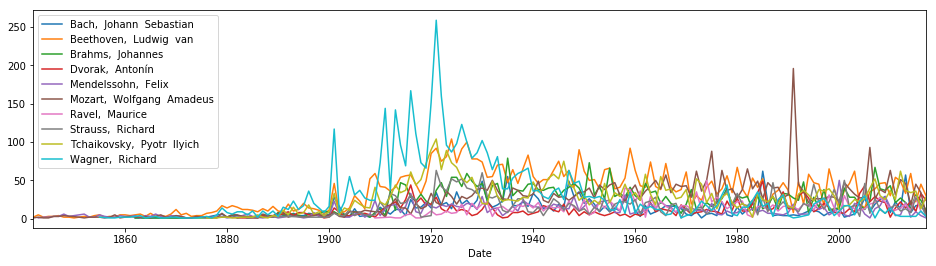

In [2079]:
fig, ax = plt.subplots(figsize=(16,4))

for label, df in popular_composers_plot.groupby('composerName'):
    df.plot(x='Date', y='count', ax=ax, label=label)
    
plt.show()

### Plot every year with rolling

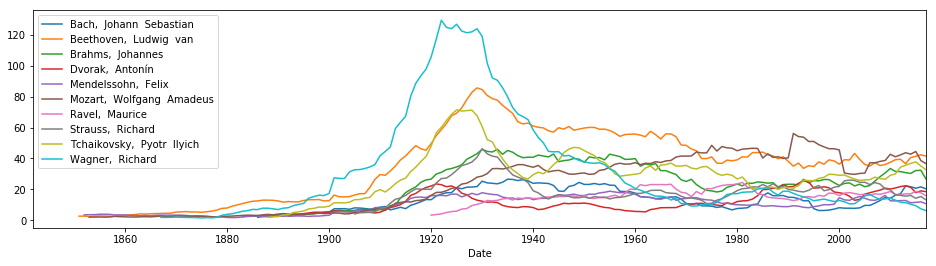

In [2096]:
fig, ax = plt.subplots(figsize=(16,4))

for label, df in popular_composers_plot.groupby('composerName'):
    df.rolling(10, on='Date').mean().plot(x='Date', y='count', ax=ax, label=label)
    
plt.show()

### Last 10 years

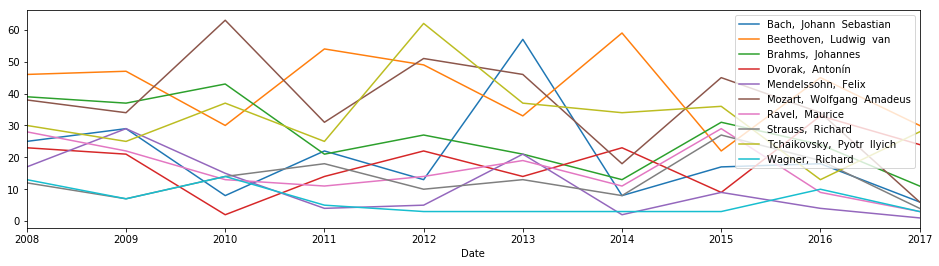

In [2099]:
fig, ax = plt.subplots(figsize=(16,4))

for label, df in popular_composers_plot[popular_composers_plot['Date'] > 2007].groupby('composerName'):
    df.plot(x='Date', y='count', ax=ax, label=label)
    
plt.show()

### Every n years

In [2113]:
years = 5
smoothed_dates_df = pd.DataFrame()

for label, df in composers_plot_data.groupby('composerName'):
    composer_name = df.head(1)['composerName'].item()
    current_df = df.groupby(df.Date // years).mean()['count'].reset_index()
    current_df['Date'] = current_df['Date'] * years
    current_df['composerName'] = composer_name
    smoothed_dates_df = smoothed_dates_df.append(current_df)

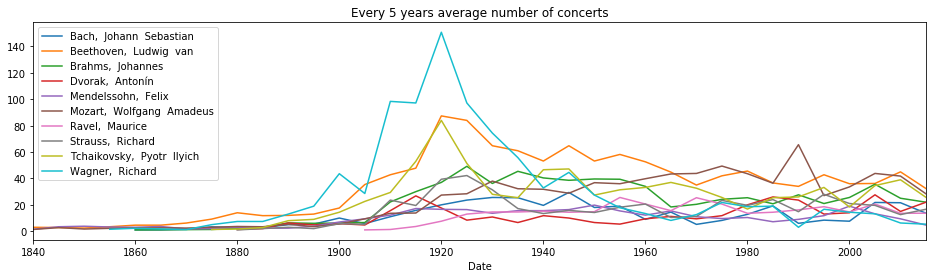

In [2125]:
fig, ax = plt.subplots(figsize=(16,4))

for label, df in smoothed_dates_df[smoothed_dates_df['composerName'] != 'Other'].groupby('composerName'):
    df.plot(x='Date', y='count', ax=ax, label=label, title='Every '+str(years)+' years average number of concerts')
    
plt.show()

### Smoothed graph

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  if sys.path[0] == '':


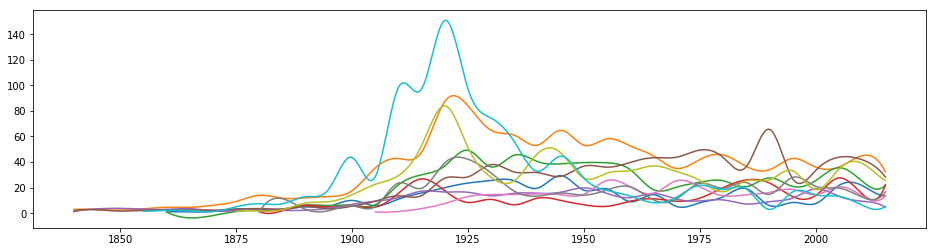

In [2115]:
fig, ax = plt.subplots(figsize=(16,4))

for label, df in smoothed_dates_df[smoothed_dates_df['composerName'] != 'Other'].groupby('composerName'):
    
    xnew = np.linspace(
        df['Date'].unique().min(),
        df['Date'].unique().max(),600)
    
    power_smooth = spline(
        list(df['Date'].unique()),
        list(df.groupby('Date').mean()['count']),
        xnew)

    plt.plot(xnew, power_smooth)

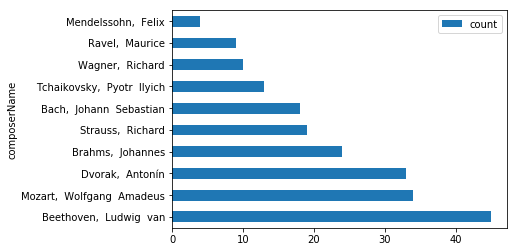

In [2116]:
popular_composers_plot[popular_composers_plot['Date'] == 2016].plot(kind='barh', y='count', x='composerName')

# Export the data as input of a D3 streamgraph

## Fill the missing dates with a count of 0

In [2117]:
df_input = smoothed_dates_df[smoothed_dates_df['composerName'] != 'Other']
data_output = []
composers = [
    'Beethoven',
    'Mendelssohn',
    'Mozart',
    'Wagner',
    'Bach',
    'Tchaikovsky',
    'Brahms',
    'Dvorak',
    'Strauss',
    'Ravel'
]

def getCompValueByYear(composer, year):
    row = (df_input[
        (df_input['composerName'].str.contains(composer))
        & (df_input['Date'] == year)])['count']
    
    return row.item() if len(row) > 0 else 0

for c in composers:
    for y in range(1842, 2017):
        if y % years == 0:
            data_output.append({
                'key': c,
                'value': getCompValueByYear(c, y),
                'date': y
            })

In [2118]:
data_output = pd.DataFrame(data_output)
data_output['key'].value_counts()

Bach           35
Brahms         35
Ravel          35
Mendelssohn    35
Beethoven      35
Mozart         35
Dvorak         35
Strauss        35
Wagner         35
Tchaikovsky    35
Name: key, dtype: int64

In [2119]:
data_output.head()

,date,key,value
0,1845,Beethoven,2.8
1,1850,Beethoven,2.4
2,1855,Beethoven,3.4
3,1860,Beethoven,4.6
4,1865,Beethoven,4.6


## Export the data

In [2120]:
streamgraph_data = data_output.sort_values(by=['key', 'date'])
streamgraph_data[['key', 'value', 'date']].to_csv('data.csv', index=False)

In [2112]:
# data_smoothed = streamgraph_data.rolling(20, on='date').mean()
# data_smoothed.fillna(0, inplace=True)
# data_smoothed[['key', 'value', 'date']].to_csv('data.csv', index=False)

In [2107]:
composers = [
    'Beethoven,  Ludwig  van',
    'Tchaikovsky,  Pyotr  Ilyich',
    'Mozart,  Wolfgang  Amadeus',
    'Brahms,  Johannes',
    'Wagner,  Richard',
    'Strauss,  Richard',
    'Mendelssohn,  Felix',
    'Bach,  Johann  Sebastian',
    'Dvorak,  Antonín',
    'Ravel,  Maurice'
]

df_composers[df_composers['composerName'].isin(composers)]['composerName'].value_counts().sum()

31789

In [1883]:
df_composers[~(df_composers['composerName'].isin(composers))]['composerName'].value_counts().sum()

56949